In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

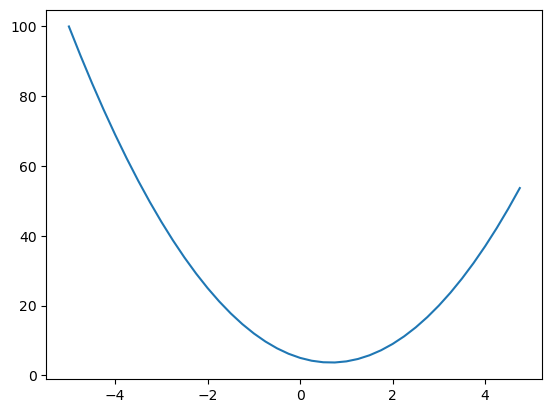

In [4]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
# applied the func f(x) for all values of xs and then saved it in ys
# then ploted them in graph

In [6]:
# finding the derivative at a point in a graph
h = 0.0000001
x = 3.0
(f(x + h) - f(x)) / h

14.000000305713911

In [7]:
# get a bit more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [59]:
class Value:
    def __init__(self,data, _children=(), _op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        '''
            when we do a + b
            it will do internally is a.__add__(b)
            so we write __nameOfFunc__ this way
        '''
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
                self.grad += 1.0 * out.grad
                other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self,other):
        '''
            when we do a * b
            it will do internally is a.__mul__(b)
            so we write __nameOfFunc__ this way
        '''
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out
            
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [10]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [11]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [12]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2* w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

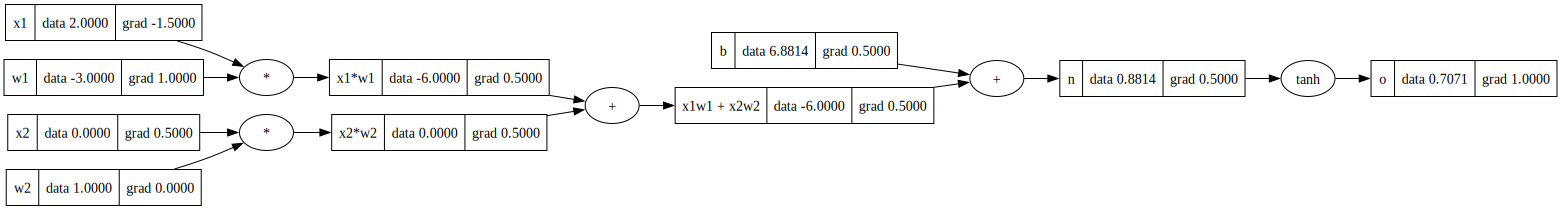

In [13]:
draw_dot(o)

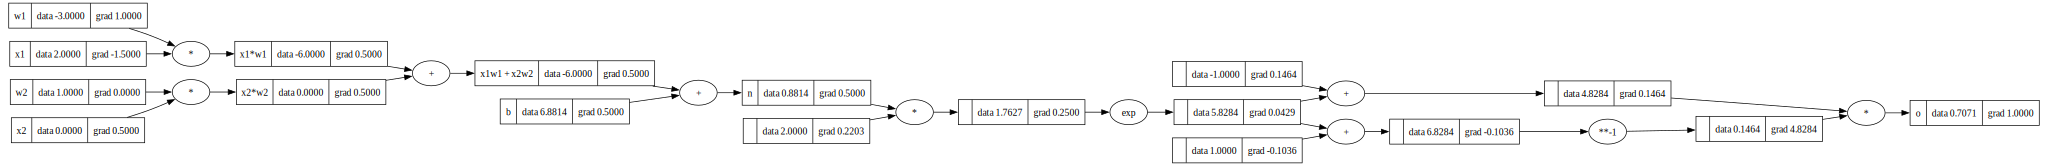

In [14]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2* w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [15]:
%pip install pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Madhav\AppData\Local\Temp\pip-install-jjhp8fic\pytorch_f969a915eff743abb028b9fdf240d8f1\setup.py", line 15, in <module>
      raise Exception(message)
  Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [16]:
import torch

In [17]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        '''
            when we create an object of Neuron class
            n = Neuron(2)
            n(x) <- here this method is called
        '''
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
            
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
 

In [69]:
len(n.parameters())

41

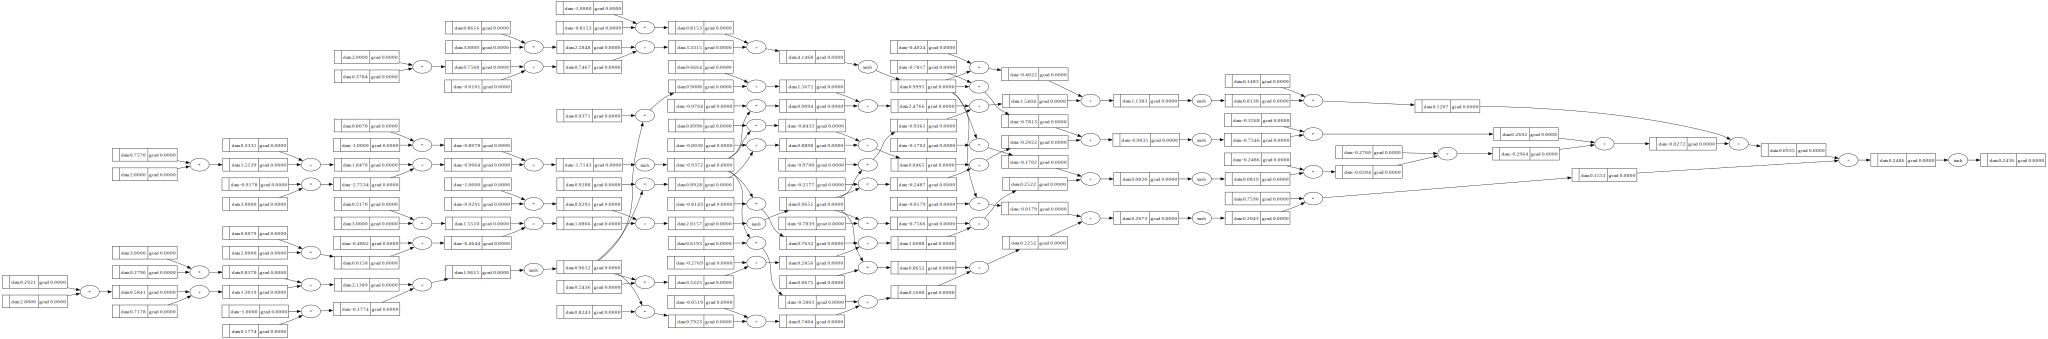

In [48]:
draw_dot(n(x))

In [104]:
   
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)
            

Value(data=-0.2729574508116498)

In [105]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [131]:
# gradient desent
for k in range(50):
    #     Forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys,ypred)), Value(0.0))

    #     Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #     Update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.0009152390987549071
1 0.0009136701799544646
2 0.0009121063477061061
3 0.0009105475778751912
4 0.0009089938464775993
5 0.0009074451296784817
6 0.0009059014037912069
7 0.0009043626452761131
8 0.0009028288307394832
9 0.0009012999369323452
10 0.0008997759407494228
11 0.0008982568192279934
12 0.0008967425495468096
13 0.0008952331090250387
14 0.0008937284751211834
15 0.0008922286254319998
16 0.0008907335376915042
17 0.0008892431897698513
18 0.0008877575596723808
19 0.0008862766255385585
20 0.00088480036564097
21 0.0008833287583842913
22 0.0008818617823043581
23 0.0008803994160671092
24 0.0008789416384676692
25 0.0008774884284293355
26 0.0008760397650026409
27 0.0008745956273644073
28 0.0008731559948167931
29 0.0008717208467863451
30 0.000870290162823118
31 0.0008688639225997185
32 0.000867442105910391
33 0.0008660246926701562
34 0.0008646116629138741
35 0.0008632029967953887
36 0.0008617986745866464
37 0.0008603986766768046
38 0.0008590029835713994
39 0.0008576115758914571
40 0.000856224

In [133]:
ypred

[Value(data=0.987567018139981),
 Value(data=-0.9900901748578882),
 Value(data=-0.9823509126090973),
 Value(data=0.9832771097885028)]